In [111]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import lightgbm as lgb

In [3]:
stores = pd.read_csv('data/stores.csv')
oil = pd.read_csv('data/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('data/holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('data/transactions.csv', parse_dates=['date'])

In [4]:
stores.info()
stores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [5]:
oil.info()
oil.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [6]:
holidays.info()
holidays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
transactions.info()
transactions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [8]:
df_aim = pd.read_csv('data/test.csv', parse_dates=['date'])

In [79]:
df = pd.read_csv('data/train.csv', parse_dates=['date'])
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [11]:
df.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [12]:
df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [13]:
df.nunique()

id             3000888
date              1684
store_nbr           54
family              33
sales           379610
onpromotion        362
dtype: int64

In [59]:
df = df.sort_values(by=['store_nbr', 'family', 'date'])

In [15]:
stores.rename(columns={'type': 'store_type'}, inplace=True)
holidays.rename(columns={'type': 'holiday_type'}, inplace=True)

In [16]:
stores.head()

,store_nbr,city,state,store_type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [80]:
# Add store type to the data
df = df.merge(stores, on='store_nbr', how='left', suffixes=('', '_drop'))
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [81]:
# Add oil prices to the data
df = df.merge(oil, on='date', how='left', suffixes=('', '_drop'))
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN


In [62]:
# Remove transferred holidays
holidays = holidays[holidays['transferred'] == False]

# Keep only valid holidays (not work days)
valid_types = ['Holiday', 'Additional', 'Bridge', 'Transfer']
holidays = holidays[holidays['holiday_type'].isin(valid_types)]

# Create three separate DataFrames for merging by locale
hol_national = holidays[holidays['locale'] == 'National'][['date', 'description']]
hol_national['is_holiday'] = True

hol_regional = holidays[holidays['locale'] == 'Regional'][['date', 'locale_name', 'description']]
hol_regional['is_holiday'] = True

hol_local = holidays[holidays['locale'] == 'Local'][['date', 'locale_name', 'description']]
hol_local['is_holiday'] = True

In [82]:
# Start with national holidays
df = df.merge(hol_national, on='date', how='left')

# Then merge regional (match on state)
df = df.merge(
    hol_regional, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left', suffixes=('', '_regional')
)

# Then merge local (match on city)
df = df.merge(
    hol_local, left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left', suffixes=('', '_local')
)

df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,description,is_holiday,locale_name,description_regional,is_holiday_regional,locale_name_local,description_local,is_holiday_local
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Primer dia del ano,True,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Primer dia del ano,True,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Primer dia del ano,True,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Primer dia del ano,True,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Primer dia del ano,True,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
# Create a single is_holiday flag: True if any of the merges matched
df['is_holiday'] = (
    df['is_holiday'].fillna(False) |
    df['is_holiday_regional'].fillna(False) |
    df['is_holiday_local'].fillna(False)
)

# Drop temporary columns
df.drop(columns=['description', 'description_regional', 'description_local',
                           'is_holiday_regional', 'is_holiday_local',
                           'locale_name', 'locale_name_local'], errors='ignore', inplace=True)


In [84]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,True
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,True
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,True
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,True
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,True


In [23]:
# Check for missing values
df.isnull().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
store_type          0
cluster             0
dcoilwtico     928686
is_holiday          0
dtype: int64

In [85]:
# Sort just in case
df = df.sort_values(by='date')


In [86]:
# Merge with df_train on date and store
df = df.merge(transactions, on=['date', 'store_nbr'], how='left')


In [87]:
df.head(10)

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,is_holiday,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,True,NaN
1,1194,2013-01-01,42,CELEBRATION,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN
2,1193,2013-01-01,42,BREAD/BAKERY,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN
3,1192,2013-01-01,42,BOOKS,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN
4,1191,2013-01-01,42,BEVERAGES,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN
5,1190,2013-01-01,42,BEAUTY,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN
6,1189,2013-01-01,42,BABY CARE,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN
7,1188,2013-01-01,42,AUTOMOTIVE,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN
8,1187,2013-01-01,41,SEAFOOD,0.0,0,Machala,El Oro,D,4,NaN,True,NaN
9,1186,2013-01-01,41,SCHOOL AND OFFICE SUPPLIES,0.0,0,Machala,El Oro,D,4,NaN,True,NaN


In [ ]:
# Time-based features
df['year'] = df['date'].dt.year              # Extracts year
df['month'] = df['date'].dt.month            # Extracts month (1–12)
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # 1 for Sat/Sun
df['day_of_month'] = df['date'].dt.day        # Day of the month (1–31)
df['week_of_year'] = df['date'].dt.isocalendar().week # Week of the year (1–53)

In [89]:
df.head(10)

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,is_holiday,transactions,year,month,day_of_week,is_weekend,day_of_month,weekofyear
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,True,NaN,2013,1,1,0,1,1
1,1194,2013-01-01,42,CELEBRATION,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN,2013,1,1,0,1,1
2,1193,2013-01-01,42,BREAD/BAKERY,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN,2013,1,1,0,1,1
3,1192,2013-01-01,42,BOOKS,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN,2013,1,1,0,1,1
4,1191,2013-01-01,42,BEVERAGES,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN,2013,1,1,0,1,1
5,1190,2013-01-01,42,BEAUTY,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN,2013,1,1,0,1,1
6,1189,2013-01-01,42,BABY CARE,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN,2013,1,1,0,1,1
7,1188,2013-01-01,42,AUTOMOTIVE,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN,2013,1,1,0,1,1
8,1187,2013-01-01,41,SEAFOOD,0.0,0,Machala,El Oro,D,4,NaN,True,NaN,2013,1,1,0,1,1
9,1186,2013-01-01,41,SCHOOL AND OFFICE SUPPLIES,0.0,0,Machala,El Oro,D,4,NaN,True,NaN,2013,1,1,0,1,1


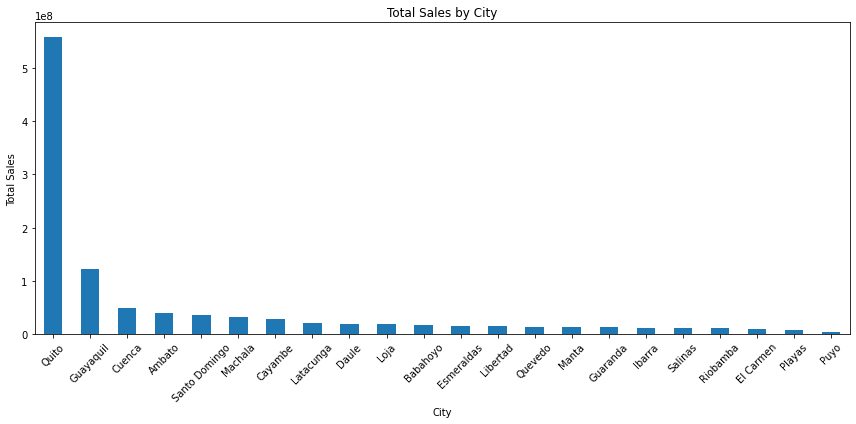

In [29]:
# Exploratory Data Analysis (EDA)

# Total sales by city
sales_by_city = df.groupby('city')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sales_by_city.plot(kind='bar')
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

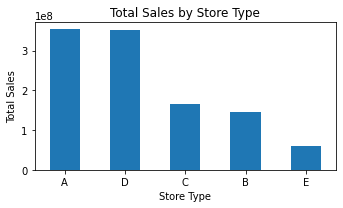

In [30]:
# Total sales by store type
sales_by_type = df.groupby('store_type')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(5, 3))
sales_by_type.plot(kind='bar')
plt.title('Total Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


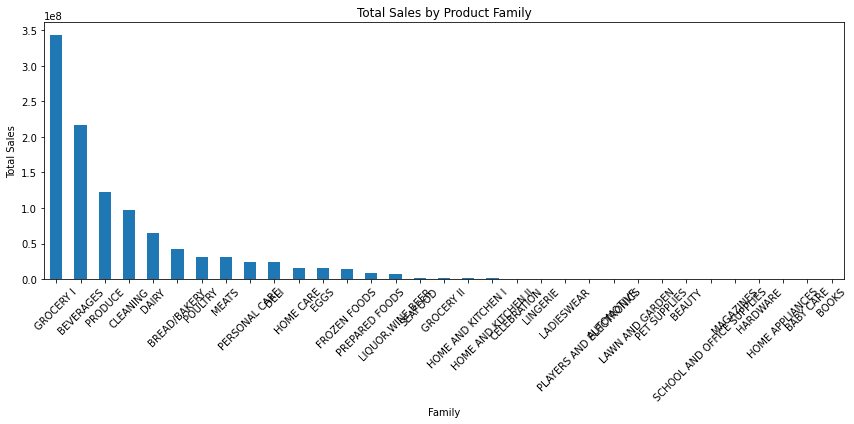

In [31]:
# Total sales by product family
sales_by_family = df.groupby('family')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sales_by_family.plot(kind='bar')
plt.title('Total Sales by Product Family')
plt.xlabel('Family')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


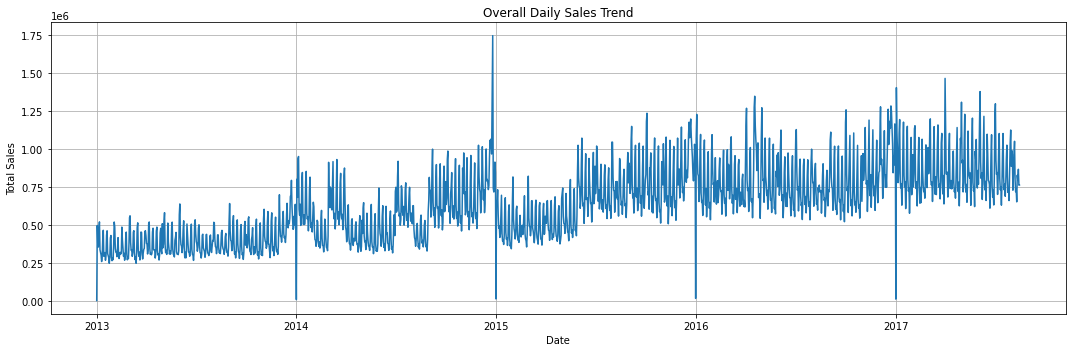

In [32]:
# Aggregate daily total sales across all stores and families
daily_sales = df.groupby('date')['sales'].sum()

# Plot the overall sales trend
plt.figure(figsize=(15, 5))
plt.plot(daily_sales.index, daily_sales.values)
plt.title('Overall Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

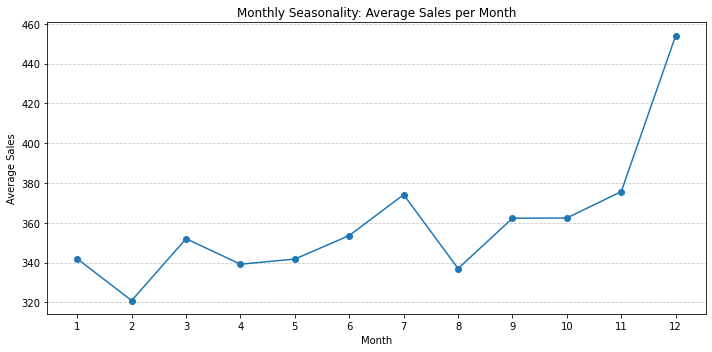

In [33]:
# Group by month and calculate average sales
monthly_avg_sales = df.groupby('month')['sales'].mean()

# Plot
plt.figure(figsize=(10, 5))
monthly_avg_sales.plot(kind='line', marker='o')
plt.title('Monthly Seasonality: Average Sales per Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

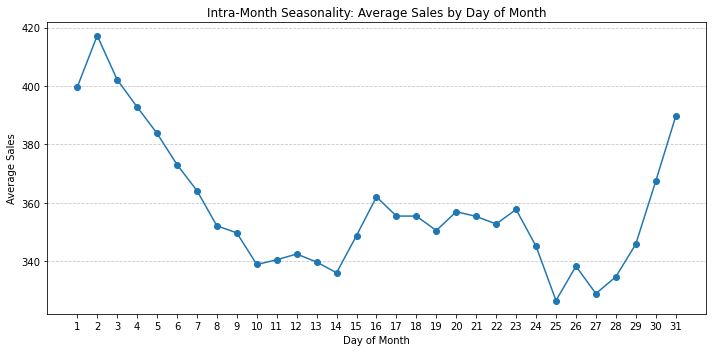

In [34]:
# Group by day of month and compute average sales
avg_sales_by_day = df.groupby('day_of_month')['sales'].mean()

# Plot
plt.figure(figsize=(10, 5))
avg_sales_by_day.plot(kind='line', marker='o')
plt.title('Intra-Month Seasonality: Average Sales by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 32))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

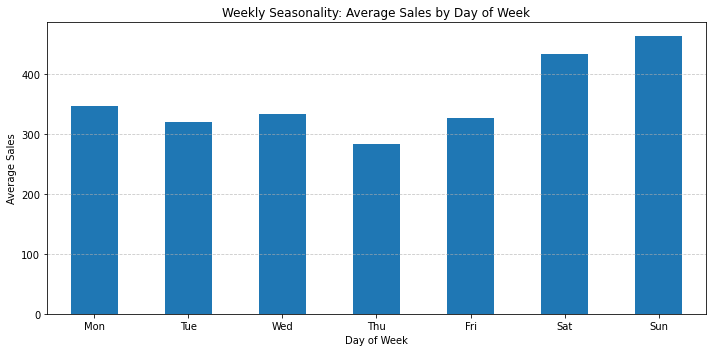

In [35]:
# Average Sales by Day of Week
plt.figure(figsize=(10, 5))
avg_sales_by_dow = df.groupby('day_of_week')['sales'].mean()
avg_sales_by_dow.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
avg_sales_by_dow.plot(kind='bar')
plt.title('Weekly Seasonality: Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


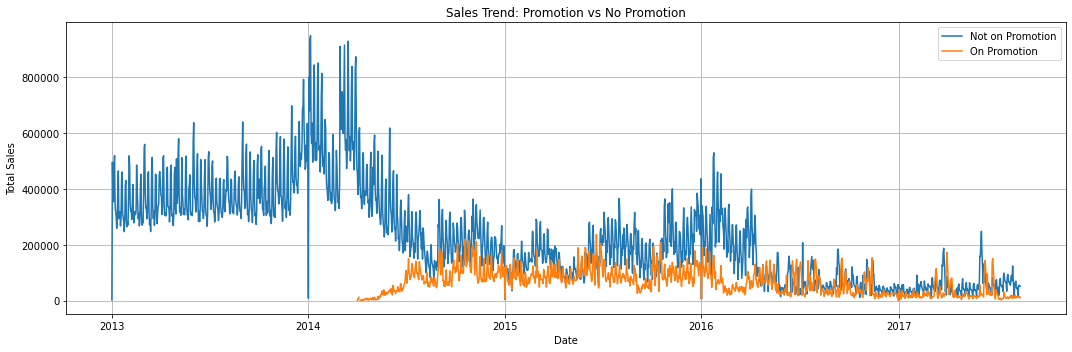

In [36]:
# Group by date and promotion status, then calculate total sales
promo_impact = df.groupby(['date', 'onpromotion'])['sales'].sum().unstack()

# Plot sales for promoted vs. non-promoted items
plt.figure(figsize=(15, 5))
plt.plot(promo_impact.index, promo_impact[0], label='Not on Promotion')
plt.plot(promo_impact.index, promo_impact[1], label='On Promotion')
plt.title('Sales Trend: Promotion vs No Promotion')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

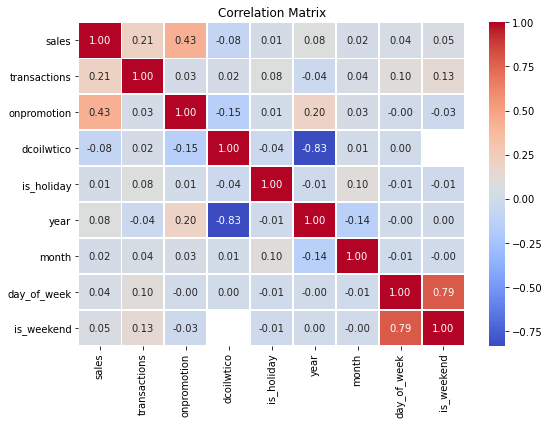

In [37]:
# Correlation Analysis
corr_cols = ['sales', 'transactions', 'onpromotion', 'dcoilwtico',
             'is_holiday', 'year', 'month', 'day_of_week', 'is_weekend']

# Compute correlation matrix
corr_matrix = df[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

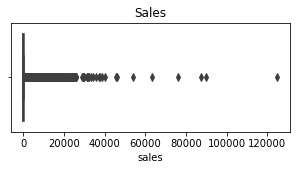

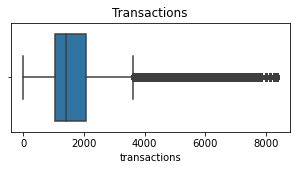

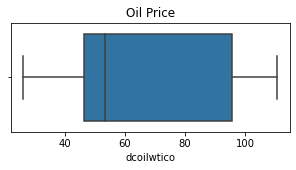

In [38]:
# Check for outliers
plt.figure(figsize=(5, 2))
sns.boxplot(x=df['sales'])
plt.title('Sales')
plt.show()

plt.figure(figsize=(5, 2))
sns.boxplot(x=df['transactions'])
plt.title('Transactions')
plt.show()

plt.figure(figsize=(5, 2))
sns.boxplot(x=df['dcoilwtico'].dropna())
plt.title('Oil Price')
plt.show()


In [ ]:
"""""
# Fill missing values

features_train_1 = features_train.copy()
features_train_1.sort_values(by=['date'], inplace=True)

# Forward-fill missing oil prices
features_train_1['dcoilwtico'] = features_train_1['dcoilwtico'].fillna(method='ffill')

# Backward-fill any remaining missing oil prices
features_train_1['dcoilwtico'] = features_train_1['dcoilwtico'].fillna(method='bfill')

# Fill missing transaction values
features_train_1['transactions'] = features_train_1['transactions'].fillna(0).astype(int)

"""

In [ ]:
# Feature Engineering
# Lag features for sales and promotion status
df['sales_lag_1'] = df.groupby(['store_nbr', 'family'])['sales'].shift(1) # Previous day's sales
df['sales_lag_7'] = df.groupby(['store_nbr', 'family'])['sales'].shift(7) # Sales from the same day last week
df['onpromotion_lag_1'] = df.groupby(['store_nbr', 'family'])['onpromotion'].shift(1) # Previous day's promotion status

# Rolling mean of sales for the last 7 days
df['rolling_mean_7'] = (
    df.groupby(['store_nbr', 'family'])['sales']
      .transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).mean())
) 

# Rolling standard deviation of sales for the last 7 days
df['rolling_std_7'] = (
    df.groupby(['store_nbr', 'family'])['sales']
      .transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).std())
)

# Promotion Intensity
df['promo_intensity'] = df.groupby('date')['onpromotion'].transform(lambda x: x / x.max())

# Create a flag for days around holidays
df['is_day_before_holiday'] = df['is_holiday'].shift(-1).fillna(0).astype(int)
df['is_day_after_holiday'] = df['is_holiday'].shift(1).fillna(0).astype(int)

# Previous Year’s Sales
df['sales_last_year'] = df.groupby(['store_nbr', 'family'])['sales'].shift(365)

In [94]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,weekofyear,sales_lag_1,sales_lag_7,onpromotion_lag_1,rolling_mean_7,rolling_std_7,promo_intensity,is_day_before_holiday,is_day_after_holiday,sales_last_year
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN
1,1194,2013-01-01,42,CELEBRATION,0.0,0,Cuenca,Azuay,D,2,...,1,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN
2,1193,2013-01-01,42,BREAD/BAKERY,0.0,0,Cuenca,Azuay,D,2,...,1,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN
3,1192,2013-01-01,42,BOOKS,0.0,0,Cuenca,Azuay,D,2,...,1,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN
4,1191,2013-01-01,42,BEVERAGES,0.0,0,Cuenca,Azuay,D,2,...,1,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN


In [95]:
# Train-Test Split
# Split the data into training and test sets
target = df.loc[:,'sales']
features = df.drop(['sales'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42) 

In [40]:
features_train.sort_values(by=['date'], inplace=True)
features_train.head()

<ipython-input-40-6063bf40667c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train.sort_values(by=['date'], inplace=True)


,id,date,store_nbr,family,onpromotion,city,state,store_type,cluster,dcoilwtico,is_holiday,transactions,year,month,day_of_week,is_weekend,day_of_month,weekofyear
710,1262,2013-01-01,44,DAIRY,0,Quito,Pichincha,A,5,NaN,True,NaN,2013,1,1,0,1,1
905,96,2013-01-01,11,PRODUCE,0,Cayambe,Pichincha,B,6,NaN,True,NaN,2013,1,1,0,1,1
329,823,2013-01-01,31,SCHOOL AND OFFICE SUPPLIES,0,Babahoyo,Los Rios,B,10,NaN,True,NaN,2013,1,1,0,1,1
468,1516,2013-01-01,50,SCHOOL AND OFFICE SUPPLIES,0,Ambato,Tungurahua,A,14,NaN,True,NaN,2013,1,1,0,1,1
1619,277,2013-01-01,17,GROCERY II,0,Quito,Pichincha,C,12,NaN,True,NaN,2013,1,1,0,1,1


In [118]:
# Baseline Model (XGBoost)
baseline_features = ['is_holiday', 'day_of_week', 'onpromotion', 'dcoilwtico', 'transactions']

X_train_baseline = features_train[baseline_features]
X_test_baseline = features_test[baseline_features]
y_train_baseline = target_train
y_test_baseline = target_test


xgb_baseline = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

# Train
xgb_baseline.fit(X_train_baseline, y_train_baseline)

# Predict
preds_baseline = xgb_baseline.predict(X_test_baseline)

# Evaluate
rmse = mean_squared_error(y_test_baseline, preds_baseline, squared=False)
mae = mean_absolute_error(y_test_baseline, preds_baseline)
r2 = r2_score(y_test_baseline, preds_baseline)

print(f"XGBoost Baseline:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

XGBoost Baseline:
RMSE: 826.17
MAE: 347.98
R²: 0.434


In [112]:
# Define categorical and numerical features
categorical_features = ['store_nbr', 'family', 'city', 'state', 'store_type']

numerical_features = [
    'onpromotion', 'cluster', 'dcoilwtico', 'weekofyear',
    'sales_lag_1', 'sales_lag_7', 'onpromotion_lag_1',
    'rolling_mean_7', 'rolling_std_7',
    'promo_intensity', 'is_day_before_holiday', 'is_day_after_holiday',
    'sales_last_year'
]

In [ ]:
#XGBoost + Feature Engeneering
xgb_features = categorical_features + numerical_features
X_train_xgb = features_train[xgb_features]
X_test_xgb = features_test[xgb_features]
y_train_xgb = target_train
y_test_xgb = target_test

# Mark categorical features as 'category' dtype
for col in categorical_features:
    X_train_xgb[col] = X_train_xgb[col].astype('category')
    X_test_xgb[col] = X_test_xgb[col].astype('category')

# Build and train the XGBoost model
xgb = XGBRegressor(
    tree_method='hist',
    enable_categorical=True,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

xgb.fit(X_train_xgb, y_train_xgb)

# Predict
preds_xgb = xgb.predict(X_test_xgb)

# Evaluate
rmse_xgb = mean_squared_error(y_test_xgb, preds_xgb, squared=False)
mae_xgb = mean_absolute_error(y_test_xgb, preds_xgb)
r2_xgb = r2_score(y_test_xgb, preds_xgb)

print("XGBoost Results:")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"R²: {r2_xgb:.3f}")

<ipython-input-104-bc4e962c76e5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-104-bc4e962c76e5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


XGBoost Results:
RMSE: 249.50
MAE: 54.97
R²: 0.948


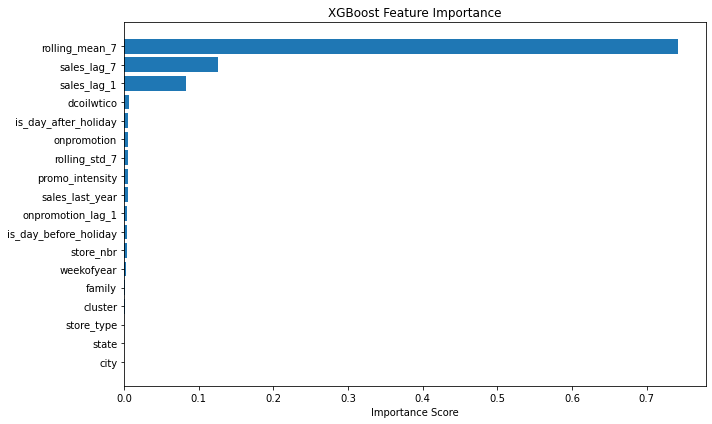

In [ ]:
# Get feature importances
importance = xgb.feature_importances_
features = X_train_xgb.columns

# Build a DataFrame for plotting
fi_df = pd.DataFrame({'Feature': features, 'Importance': importance})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(fi_df['Feature'], fi_df['Importance'])
plt.gca().invert_yaxis()  # highest at top
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [ ]:
# XGB + OneHotEncoder
categorical_ohe = ['family', 'store_type']
other_categoricals = ['store_nbr', 'city', 'state'] 
numerical_features_ohe = [
    'onpromotion', 'cluster', 'dcoilwtico', 'weekofyear',
    'sales_lag_1', 'sales_lag_7', 'onpromotion_lag_1',
    'rolling_mean_7', 'rolling_std_7', 'promo_intensity',
    'is_day_before_holiday', 'is_day_after_holiday', 'sales_last_year'
]

# Final feature set
features_xgb_ohe = numerical_features + categorical_ohe

# One-Hot Encoder
encoder = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_ohe)
    ],
    remainder='passthrough' 
)

# Build Pipeline
pipeline_xgb = Pipeline([
    ('encoder', encoder),
    ('xgb', XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ))
])

# Train
pipeline_xgb.fit(features_train[features_xgb_ohe], target_train)

# Predict and evaluate
preds_xgb_ohe = pipeline_xgb.predict(features_test[features_xgb_ohe])
rmse_xgb_ohe = mean_squared_error(target_test, preds_xgb_ohe, squared=False)
mae_xgb_ohe = mean_absolute_error(target_test, preds_xgb_ohe)
r2_xgb_ohe = r2_score(target_test, preds_xgb_ohe)

print("XGBoost with One-Hot Encoding:")
print(f"RMSE: {rmse_xgb_ohe:.2f}")
print(f"MAE: {mae_xgb_ohe:.2f}")
print(f"R²: {r2_xgb_ohe:.3f}")

📊 XGBoost with One-Hot Encoding Results:
RMSE: 255.37
MAE: 56.67
R²: 0.946


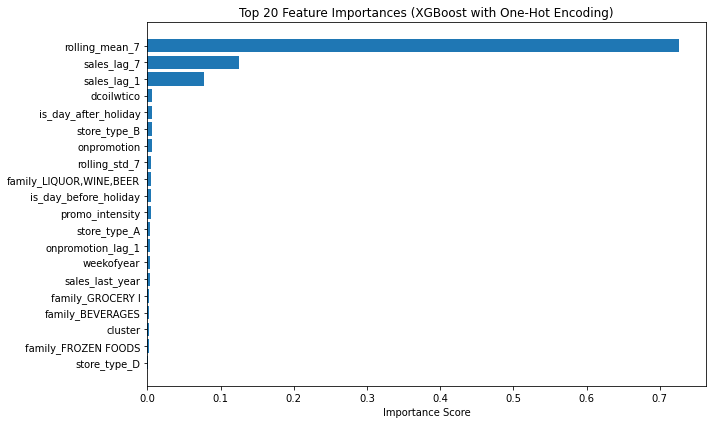

In [ ]:
xgb_model = pipeline_xgb.named_steps['xgb']

# Get feature names from encoder
# Get one-hot encoded feature names
onehot_feature_names = pipeline_xgb.named_steps['encoder'].named_transformers_['onehot'].get_feature_names(categorical_ohe)

# Combine with numerical feature names
final_feature_names = list(onehot_feature_names) + numerical_features

# Get importances and map them
importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])  # top 20
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances (XGBoost with One-Hot Encoding)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [ ]:
# LightGBM Model with Feature Engineering
# Combine features
selected_features = categorical_features + numerical_features

# Subset the data
X_train_light = features_train[selected_features]
X_test_light = features_test[selected_features]
y_train_light = target_train
y_test_light = target_test

# Convert categoricals to 'category' dtype
for col in categorical_features:
    X_train_light[col] = X_train_light[col].astype('category')
    X_test_light[col] = X_test_light[col].astype('category')

# Initialize and train LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train_light, y_train_light)

# Predict
preds_light = lgb_model.predict(X_test_light)

# Evaluate
rmse_light = mean_squared_error(y_test_light, preds_light, squared=False)
mae_light = mean_absolute_error(y_test_light, preds_light)
r2_light = r2_score(y_test_light, preds_light)

print("LightGBM Results:")
print(f"RMSE: {rmse_light:.2f}")
print(f"MAE: {mae_light:.2f}")
print(f"R²: {r2_light:.3f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2404
[LightGBM] [Info] Number of data points in the train set: 2402347, number of used features: 18
[LightGBM] [Info] Start training from score 357.985429
LightGBM Results:
RMSE: 253.73
MAE: 56.88
R²: 0.947


In [ ]:
#XGBoost + Feature Engeneering + Grid Search
# Define the parameter grid
param_dist = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

# Re-define X and y using selected features
selected_features = categorical_features + numerical_features
X_train_xgb_tuned = features_train[selected_features]
X_test_xgb_tuned = features_test[selected_features]
y_train_xgb_tuned = target_train
y_test_xgb_tuned = target_test

# Ensure categorical columns are properly typed
for col in categorical_features:
    X_train_xgb_tuned[col] = X_train_xgb_tuned[col].astype('category')
    X_test_xgb_tuned[col] = X_test_xgb_tuned[col].astype('category')

# Initialize model
xgb_tuned = XGBRegressor(
    n_estimators=100,
    tree_method='hist',
    enable_categorical=True,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Wrap in RandomizedSearchCV
search = RandomizedSearchCV(
    xgb_tuned,
    param_distributions=param_dist,
    n_iter=20,  # number of parameter combinations to try
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit
search.fit(X_train_xgb_tuned, y_train_xgb_tuned)

# Best model
best_model = search.best_estimator_

# Predict and evaluate
preds_xgb_tuned = best_model.predict(X_test_xgb_tuned)
rmse_xgb_tuned = mean_squared_error(y_test_xgb_tuned, preds_xgb_tuned, squared=False)
mae_xgb_tuned = mean_absolute_error(y_test_xgb_tuned, preds_xgb_tuned)
r2_xgb_tuned = r2_score(y_test_xgb_tuned, preds_xgb_tuned)

print("XGBoost (Tuned) Results:")
print(f"Best Params: {search.best_params_}")
print(f"RMSE: {rmse_xgb_tuned:.2f}")
print(f"MAE: {mae_xgb_tuned:.2f}")
print(f"R²: {r2_xgb_tuned:.3f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost (Tuned) Results:
Best Params: {'subsample': 0.6, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
RMSE: 237.44
MAE: 51.06
R²: 0.953


In [117]:
features_train.isnull().sum()

id                            0
date                          0
store_nbr                     0
family                        0
onpromotion                   0
city                          0
state                         0
store_type                    0
cluster                       0
dcoilwtico               743008
is_holiday                    0
transactions             196877
year                          0
month                         0
day_of_week                   0
is_weekend                    0
day_of_month                  0
weekofyear                    0
sales_lag_1                1413
sales_lag_7               10018
onpromotion_lag_1          1413
rolling_mean_7             1413
rolling_std_7              2852
promo_intensity          647209
is_day_before_holiday         0
is_day_after_holiday          0
sales_last_year          520319
dtype: int64